In [ ]:
import math
from pathlib import Path
import matplotlib.style
import matplotlib as mpl
import torch

DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)
mpl.style.use("default")

checkpoint = torch.load('./model.pt')

site = ["DRIAMS-B"]

path = Path(f"./{site[0]}-results/")
path.mkdir(parents=True, exist_ok=True)

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    sites=site,
    antibiotics= checkpoint["selected_antibiotics"],
    cutoff_value= None,
    cutoff_value_negative= None,
    cutoff_value_positive= None
)

driams.loading_type = "memory"

driams.label_stats

/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2015) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2016) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2017) combination not found!
  warnings.warn(


Loading Spectra into Memory:   0%|          | 0/2371 [00:00<?, ?it/s]

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin-Amoxicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,...,Meropenem,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Rifampicin,Teicoplanin,Tetracycline,Tobramycin
positive,26,536,0,0,269,0,106,115,304,339,...,11,534,143,186,0,188,13,10,130,0
negative,900,1454,0,0,1420,0,834,970,499,1680,...,905,481,657,545,0,987,789,736,747,0
n_sum,926,1990,0,0,1689,0,940,1085,803,2019,...,916,1015,800,731,0,1175,802,746,877,0


In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=30, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
from torch.utils.data import DataLoader

test_size = len(driams)
test_loader = DataLoader(driams, batch_size= test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
model = model.to(DEVICE)

test_features = test_features.view(test_size, 18000)
test_features = test_features.to(DEVICE)

test_labels = test_labels.view(test_size, len(driams.selected_antibiotics))
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

(0.7852919697761536, 0.7451943592591719)


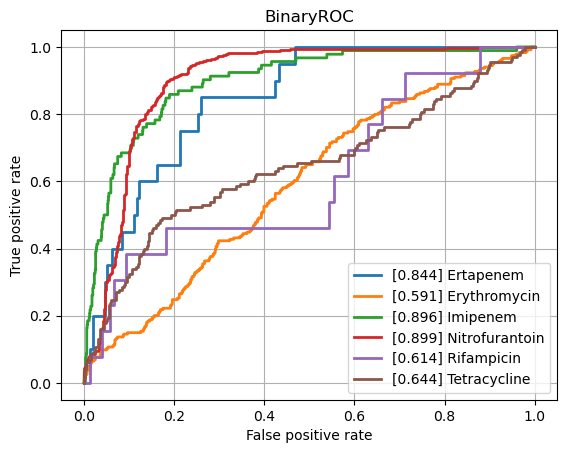

In [ ]:
from matplotlib import pyplot as plt
from maldi2resistance.metric.ROC import MultiLabelRocNan

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv=path /"ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig(path / "ROC.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.45255500078201294, 0.34830358023331925)


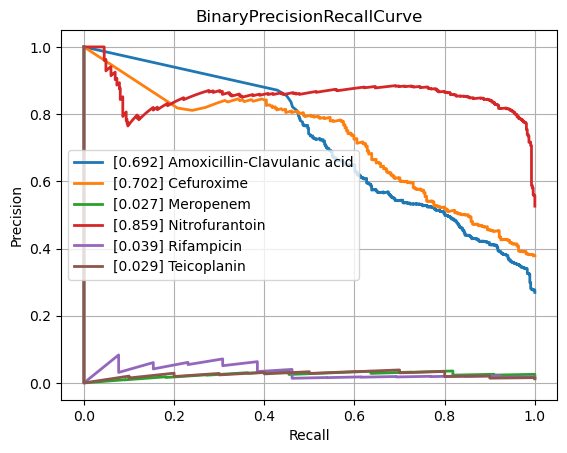

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv=path / "PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig(path / "PrecisionRecall.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv(path / f"/results{site[0]}.csv", sep=",")
df

,class,PrecisionRecallAUC,FrequencyPositiveClass
0,Amikacin,0.163957,0.028078
1,Amoxicillin-Clavulanic acid,0.720080,0.269347
2,Ampicillin-Amoxicillin,NaN,NaN
3,Cefazolin,NaN,NaN
4,Cefepime,0.486083,0.159266
5,Cefpodoxime,NaN,NaN
6,Ceftazidime,0.181160,0.112766
7,Ceftriaxone,0.194783,0.105991
8,Cefuroxime,0.720500,0.378580
9,Ciprofloxacin,0.382404,0.167905


In [ ]:
gen = torch.Generator()
split_sizes = [int(len(driams)*0.1)] *9 + [len(driams) - int(len(driams)*0.1) * 9]#

splits = torch.utils.data.random_split(driams, split_sizes, generator=gen.manual_seed(SEED))

In [ ]:
del ml_pr, ml_roc
torch.cuda.empty_cache()

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from torch.optim import Adam
from typing import Sequence
from torch.utils.data import Subset


# lr=0.00001 works better

optimizer = Adam(model.parameters(),lr=1e-4, amsgrad = True)
DEVICE = torch.device("cpu")

for idx, split in enumerate(splits):
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model = model.to(DEVICE)
    
    train_indices: Sequence = []
    test_indices: Sequence = []
    
    for i in range(0, 10):
        if idx > i:
             train_indices += splits[i].indices
        else:
            test_indices+= splits[i].indices
    
    test_data = DataLoader(Subset(driams, test_indices), batch_size= len(test_indices), shuffle=True, drop_last=True, generator=gen.manual_seed(SEED))
    test_features, test_labels = next(iter(test_data))
    test_features = test_features.to(DEVICE)
        
    results_without_finetuning = model(test_features)
    torch.cuda.empty_cache()
    
    if idx != 0:
        train_data = DataLoader(Subset(driams, train_indices), batch_size= len(train_indices), shuffle=True, drop_last=True, generator=gen.manual_seed(SEED))
        train_features, train_labels = next(iter(train_data))
        train_features = train_features.to(DEVICE)
        class_weights_negative = []
        class_weights_positive = []
        
        for antibiotic_idx in range(0, len(driams.selected_antibiotics)):
            
            part = train_labels[: , antibiotic_idx]
            mask = torch.isnan(part)
            
            part = part[~mask]
            
            occurrences = torch.bincount(part.int())
            values = torch.numel(part)
            
            try:
                positives = occurrences[1].item()/values
            except IndexError:
                positives = 0
                
            class_weights_negative.append(positives)
            class_weights_positive.append(1- positives)
            
            del part,mask,occurrences, values, positives
            torch.cuda.empty_cache()

        
        DEVICE = torch.device("cuda")    
        criterion = MaskedBCE(class_weights_negative = torch.tensor(class_weights_negative, requires_grad=False).to(DEVICE), class_weights_positive = torch.tensor(class_weights_positive, requires_grad=False).to(DEVICE))
        
        model = model.to(DEVICE)
        train_features = train_features.to(DEVICE)
        train_labels = train_labels.to(DEVICE)
        
        model.train()
        
        for epoch in range(5):
            
            optimizer.zero_grad()
            output = model(train_features)
            loss = criterion(output, train_labels)
            loss.backward()
            optimizer.step()
        
        del criterion
        
        DEVICE = torch.device("cpu")
        model = model.to(DEVICE)
        train_features = train_features.to(DEVICE)
        train_labels = train_labels.to(DEVICE)
        
        if idx == 9:
            torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './modelWith90@SiteB.pt')
            
    model.eval()
    
    torch.cuda.empty_cache()
    
    test_labels = test_labels.to(DEVICE)
    test_features = test_features.to(DEVICE)
    
    results_with_finetuning = model(test_features)
    
    ml_roc = MultiLabelRocNan()
    fig_name = f"ROC_with_finetuning{idx}0train_percent"
    ml_roc.compute(results_with_finetuning,test_labels,driams.selected_antibiotics, create_csv=path / (fig_name + ".csv"))    
    fig_, ax_ = ml_roc()
    plt.savefig(path / (fig_name + ".png"), transparent=True, format= "png", bbox_inches = "tight")
    plt.close()
    
    ml_roc = MultiLabelRocNan()
    fig_name = f"ROC_without_finetuning{idx}0train_percent"
    ml_roc.compute(results_without_finetuning,test_labels,driams.selected_antibiotics, create_csv=path / (fig_name + ".csv"))
    fig_, ax_ = ml_roc()
    plt.savefig(path / (fig_name + ".png"), transparent=True, format= "png", bbox_inches = "tight")
    plt.close()

    ml_pr = MultiLabelPRNan()
    fig_name = f"PrecisionRecall_with_finetuning{idx}0train_percent"
    ml_pr.compute(results_with_finetuning,test_labels,driams.selected_antibiotics, create_csv=path / (fig_name + ".csv"))
    fig_, ax_ = ml_pr()
    plt.savefig(path / (fig_name +".png"), transparent=True, format= "png", bbox_inches = "tight")
    plt.close()
    
    ml_pr = MultiLabelPRNan()
    fig_name = f"PrecisionRecall_without_finetuning{idx}0train_percent"
    ml_pr.compute(results_without_finetuning,test_labels,driams.selected_antibiotics, create_csv= path / (fig_name + ".csv"))
    fig_, ax_ = ml_pr()
    plt.savefig(path / (fig_name +".png"), transparent=True, format= "png", bbox_inches = "tight")
    plt.close()
    
    # the garbage collector runs otherwise not regularly
    del results_without_finetuning, results_with_finetuning, test_features, test_labels, ml_pr, ml_roc
    if idx != 0:
        del train_features, train_labels
    
    torch.cuda.empty_cache()

/home/jan/anaconda3/envs/master_backend/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jan/anaconda3/envs/master_backend/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
import pandas as pd

dfs = []

average_diff_per_antibiotic = {}

for antibiotic in driams.selected_antibiotics:
    average_diff_per_antibiotic[antibiotic] = 0

for i in range(0, 10):
    
    new_frame = pd.merge(pd.read_csv(path / f"PrecisionRecall_with_finetuning{i}0train_percent.csv"), pd.read_csv(path / f"PrecisionRecall_without_finetuning{i}0train_percent.csv"), on=["class", "FrequencyPositiveClass"], how='outer', suffixes=('_with_finetuning','_without_finetuning'))
    
    for antibiotic in driams.selected_antibiotics:
        row = new_frame[new_frame["class"] == antibiotic]
        value = (average_diff_per_antibiotic[antibiotic] + (float(row["PrecisionRecallAUC_with_finetuning"].iloc[0]) -float( row["PrecisionRecallAUC_without_finetuning"].iloc[0])) / 10)
        average_diff_per_antibiotic[antibiotic] = value 
        
    dfs.append(new_frame)

average_change = pd.DataFrame.from_dict(average_diff_per_antibiotic, orient = "index")
average_change

,0
Amikacin,0.010542
Amoxicillin-Clavulanic acid,0.046854
Ampicillin-Amoxicillin,NaN
Cefazolin,NaN
Cefepime,0.076547
Cefpodoxime,NaN
Ceftazidime,0.013066
Ceftriaxone,0.021034
Cefuroxime,0.003087
Ciprofloxacin,0.087824


In [ ]:
len(dfs)

10

/tmp/ipykernel_11485/2841677684.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bar_plot_df = pd.concat([bar_plot_df,antiobiotic_row])
/tmp/ipykernel_11485/2841677684.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bar_plot_df = pd.concat([bar_plot_df,antiobiotic_row])
/tmp/ipykernel_11485/2841677684.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when dete

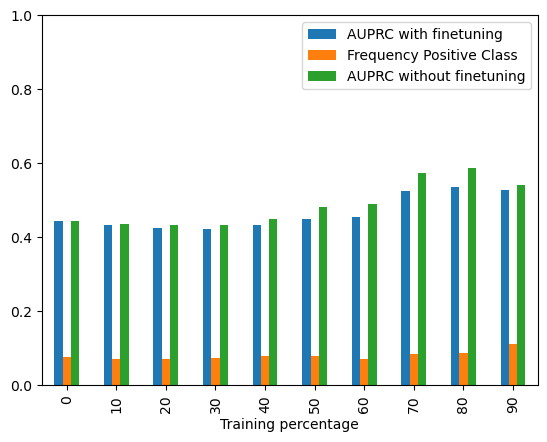

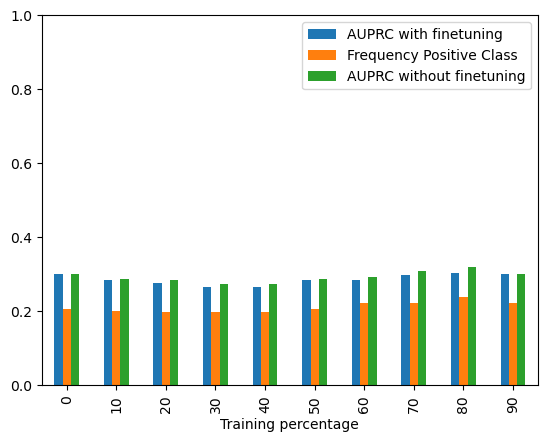

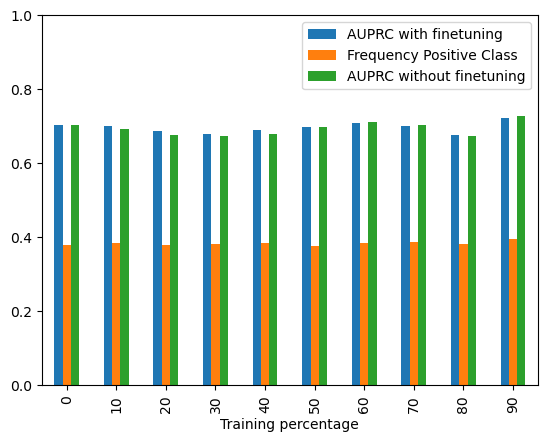

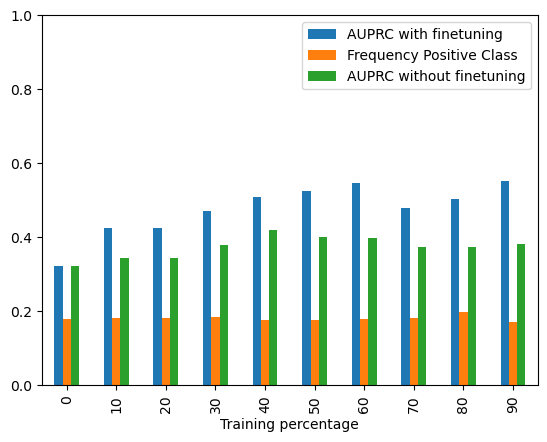

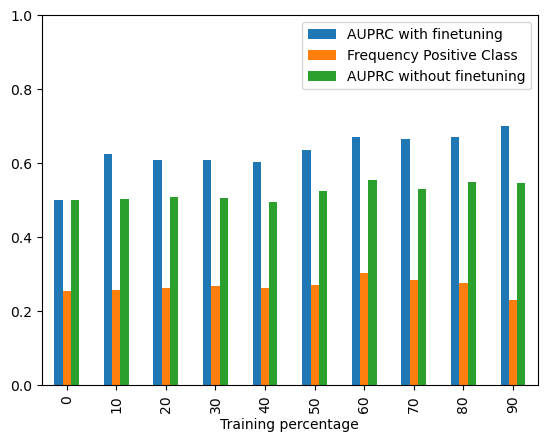

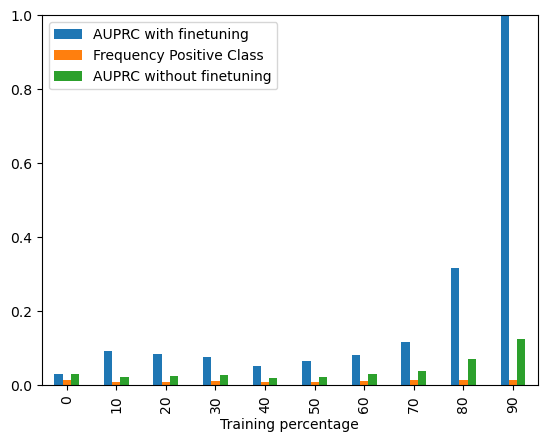

In [ ]:
df_antibiotic = {}

for antibiotic in ["Imipenem", "Clindamycin","Cefuroxime", "Norfloxacin" ,"Oxacillin","Teicoplanin"]:
    bar_plot_df = pd.DataFrame(columns=["PrecisionRecallAUC_with_finetuning", "FrequencyPositiveClass", "PrecisionRecallAUC_without_finetuning", "trainingPercent"])
    
    for i in range(0, 10):
        
        df = dfs[i]
        antiobiotic_row = df[df["class"] == antibiotic]
        antiobiotic_row = antiobiotic_row[antiobiotic_row.columns.drop('class')]
        antiobiotic_row["trainingPercent"] = i*10
        
        bar_plot_df = pd.concat([bar_plot_df,antiobiotic_row])
        
    bar_plot_df = bar_plot_df.set_index('trainingPercent')
    ax = bar_plot_df.loc[:,["PrecisionRecallAUC_with_finetuning", "FrequencyPositiveClass", "PrecisionRecallAUC_without_finetuning"]].plot.bar(ylim = (0,1))     
    ax.legend(['AUPRC with finetuning', 'Frequency Positive Class', "AUPRC without finetuning"])
    plt.xlabel("Training percentage")
    
    fig_name = f"FineTuningProgress-{antibiotic}"
    ax.figure.savefig(path / (fig_name + ".png"), transparent=True, format= "png", bbox_inches = "tight")
    

In [ ]:
l = ax.get_legend_handles_labels()
ax.legend(['AUPRC with finetuning', 'Frequency Positive Class', "AUPRC without finetuning"])

for label in l:
    print(label)

In [ ]:

l = ax.get_legend_handles_labels()

ax.legend()

for label in l:
    print(label)

[<BarContainer object of 10 artists>, <BarContainer object of 10 artists>, <BarContainer object of 10 artists>]
['PrecisionRecallAUC_with_finetuning', 'FrequencyPositiveClass', 'PrecisionRecallAUC_without_finetuning']


In [ ]:
import pandas as pd

dfs = []

average_diff_per_antibiotic = {}

for antibiotic in driams.selected_antibiotics:
    average_diff_per_antibiotic[antibiotic] = 0

for i in range(9, 10):
    
    new_frame = pd.merge(pd.read_csv(path / f"PrecisionRecall_with_finetuning{i}0train_percent.csv"), pd.read_csv(path / f"PrecisionRecall_without_finetuning{i}0train_percent.csv"), on=["class", "FrequencyPositiveClass"], how='outer', suffixes=('_with_finetuning','_without_finetuning'))
    
    for antibiotic in driams.selected_antibiotics:
        row = new_frame[new_frame["class"] == antibiotic]
        value = (average_diff_per_antibiotic[antibiotic] + (float(row["PrecisionRecallAUC_with_finetuning"].iloc[0]) -float( row["PrecisionRecallAUC_without_finetuning"].iloc[0])) / 1)
        average_diff_per_antibiotic[antibiotic] = value 
        
    dfs.append(new_frame)

change_90 = pd.DataFrame.from_dict(average_diff_per_antibiotic, orient = "index")
change_90

,0
Amikacin,0.023077
Amoxicillin-Clavulanic acid,0.033725
Ampicillin-Amoxicillin,NaN
Cefazolin,NaN
Cefepime,0.085839
Cefpodoxime,NaN
Ceftazidime,-0.020324
Ceftriaxone,0.009873
Cefuroxime,-0.005278
Ciprofloxacin,0.047659


In [ ]:
latex = average_change.merge(change_90, left_index=True, right_index=True, suffixes = ["Average","90% train"])
print(latex.to_latex())

\begin{tabular}{lrr}
\toprule
 & 0Average & 090% train \\
\midrule
Amikacin & 0.010542 & 0.023077 \\
Amoxicillin-Clavulanic acid & 0.046854 & 0.033725 \\
Ampicillin-Amoxicillin & NaN & NaN \\
Cefazolin & NaN & NaN \\
Cefepime & 0.076547 & 0.085839 \\
Cefpodoxime & NaN & NaN \\
Ceftazidime & 0.013066 & -0.020324 \\
Ceftriaxone & 0.021034 & 0.009873 \\
Cefuroxime & 0.003087 & -0.005278 \\
Ciprofloxacin & 0.087824 & 0.047659 \\
Clindamycin & -0.006798 & 0.000209 \\
Colistin & NaN & NaN \\
Cotrimoxazole & NaN & NaN \\
Ertapenem & 0.061640 & 0.000000 \\
Erythromycin & 0.019574 & 0.008502 \\
Fosfomycin-Trometamol & NaN & NaN \\
Fusidic acid & 0.014077 & 0.023903 \\
Gentamicin & 0.031086 & 0.026411 \\
Imipenem & -0.021808 & -0.013080 \\
Levofloxacin & 0.087328 & 0.071174 \\
Meropenem & 0.016752 & 0.039948 \\
Nitrofurantoin & 0.029706 & 0.007048 \\
Norfloxacin & 0.102446 & 0.170376 \\
Oxacillin & 0.106432 & 0.152704 \\
Penicillin & NaN & NaN \\
Piperacillin-Tazobactam & 0.034626 & 0.087607 \\
